In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
df = pd.read_csv("C:/Users/pkitt/Downloads/playground-series-s5e6/train.csv")

In [4]:
df.cat =df.select_dtypes(include=[object]) 

C:\Users\pkitt\AppData\Local\Temp\ipykernel_24112\1653857449.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.cat =df.select_dtypes(include=[object])


In [5]:
df.num=df.select_dtypes(include=[np.number])

C:\Users\pkitt\AppData\Local\Temp\ipykernel_24112\610118065.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.num=df.select_dtypes(include=[np.number])


In [6]:
df.cat.head()

,Soil Type,Crop Type,Fertilizer Name
0,Clayey,Sugarcane,28-28
1,Sandy,Millets,28-28
2,Sandy,Millets,17-17-17
3,Sandy,Barley,10-26-26
4,Red,Paddy,DAP


In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
le = LabelEncoder()

In [9]:
df.cat["Soil Type"] = le.fit_transform(df.cat["Soil Type"])

In [10]:
df.cat["Crop Type"] = le.fit_transform(df.cat["Crop Type"])

In [11]:
df.cat["Fertilizer Name"] = le.fit_transform(df.cat["Fertilizer Name"])

In [12]:
df.cat.tail(20)

,Soil Type,Crop Type,Fertilizer Name
749980,0,10,5
749981,2,2,2
749982,3,8,0
749983,4,3,2
749984,4,6,1
749985,3,3,0
749986,0,10,3
749987,3,3,6
749988,0,3,1
749989,0,4,4


In [13]:
df_train = pd.concat([df.num,df.cat],axis=1)

In [14]:
matrix=df_train.corr()

In [15]:
matrix

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Soil Type,Crop Type,Fertilizer Name
id,1.000000,-0.001069,-0.000310,0.001752,0.001505,-0.000375,-0.001234,0.002831,-0.000953,-0.000179
Temparature,-0.001069,1.000000,0.001758,-0.001633,-0.006073,-0.009913,0.000298,-0.007621,-0.006753,0.001727
Humidity,-0.000310,0.001758,1.000000,0.003424,0.006502,0.005229,0.002413,0.003921,0.002414,0.010626
Moisture,0.001752,-0.001633,0.003424,1.000000,0.003016,-0.001931,-0.006735,-0.003941,-0.003400,0.011493
Nitrogen,0.001505,-0.006073,0.006502,0.003016,1.000000,0.000543,-0.005464,-0.000650,0.001611,-0.004725
Potassium,-0.000375,-0.009913,0.005229,-0.001931,0.000543,1.000000,0.000113,0.005314,-0.003748,-0.010872
Phosphorous,-0.001234,0.000298,0.002413,-0.006735,-0.005464,0.000113,1.000000,-0.000275,0.000694,-0.006127
Soil Type,0.002831,-0.007621,0.003921,-0.003941,-0.000650,0.005314,-0.000275,1.000000,-0.006213,0.016576
Crop Type,-0.000953,-0.006753,0.002414,-0.003400,0.001611,-0.003748,0.000694,-0.006213,1.000000,-0.013041
Fertilizer Name,-0.000179,0.001727,0.010626,0.011493,-0.004725,-0.010872,-0.006127,0.016576,-0.013041,1.000000


In [16]:
X = df_train[["Temparature","Humidity","Moisture","Crop Type","Soil Type"]]

In [17]:
y = df_train[["Fertilizer Name"]]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from kan import MultKAN  # or FastKAN depending on the repo
from kan import MultKAN as KAN
from kan.utils import create_dataset

model = KAN(width=[5, 10, 7], grid=5, k=5, noise_scale=0.3, seed=42)
f = lambda x: (
    0.5 * x[:, [0]]**2 +
    0.3 * x[:, [1]]**2 +
    0.2 * x[:, [2]] +
    .5 * x[:, [3]] +
    1 * x[:, [4]]
)
dataset = create_dataset(f, n_var=5)
#dataset = create_dataset(f, n_var=3)
model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
model.attribute()
model.feature_score

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-02 | test_loss: 1.80e-02 | reg: 1.50e+01 | : 100%|█| 20/20 [00:45<00:00,  2.29s/

saving model version 0.1


tensor([0.2227, 0.1308, 0.1674, 0.4283, 0.8757], grad_fn=<MeanBackward1>)

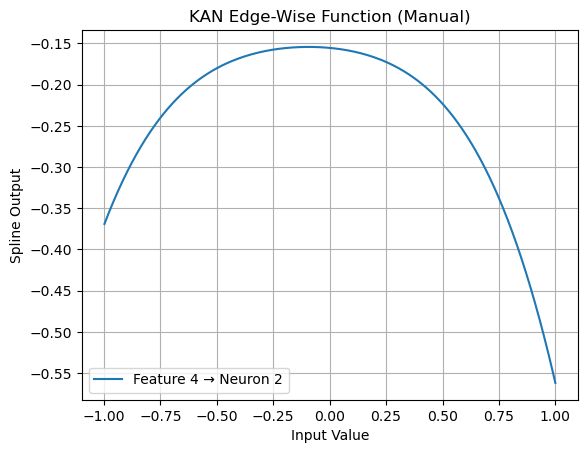

In [24]:
import torch
import matplotlib.pyplot as plt

# Extract grid and coefficients
in_idx = 4  # input feature index
out_idx = 2  # output neuron index

grid = model.act_fun[0].grid[in_idx].detach()
coef = model.act_fun[0].coef[:, in_idx, out_idx].detach()

# Evaluate spline manually (simple linear interpolation)
x_vals = torch.linspace(grid[model.k], grid[-model.k-1], steps=200)
y_vals = torch.zeros_like(x_vals)

for i in range(len(coef)):
    y_vals += coef[i] * torch.pow(x_vals, i)

# Plot
plt.plot(x_vals.numpy(), y_vals.numpy(), label=f'Feature {in_idx} → Neuron {out_idx}')
plt.title('KAN Edge-Wise Function (Manual)')
plt.xlabel('Input Value')
plt.ylabel('Spline Output')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score

def evaluate_kan_model(model, X_test, y_test):
    try:
        print("Function started ")
        X_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
        y_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).squeeze()

        model.eval()
        with torch.no_grad():
            outputs = model(X_tensor)
            predicted = torch.argmax(outputs, dim=1)

        acc = accuracy_score(y_tensor.numpy(), predicted.numpy())
        loss = nn.CrossEntropyLoss()(outputs, y_tensor).item()

        print(f" Accuracy: {acc:.4f} | 📉 Loss: {loss:.4f}")
    except Exception as e:
        print(f" Error inside evaluate_kan_model: {e}")

In [26]:
evaluate_kan_model(model, X_test, y_test)

Function started 
 Accuracy: 0.1508 | 📉 Loss: 2.0431
